In [1]:
import numpy as np
import math
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [59]:
# Activation functions 

class Sigmoid:
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class Softmax:
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    def loss_func(self, Y, Z=None):
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

In [60]:
# FC layer

class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    def forward(self, X):
        self.X = X
        A = X@self.W + self.B
        return A
    def backward(self, dA):
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

In [61]:
# initializers
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
        
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B


In [62]:
# optimizers
class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB


In [63]:
#batch size

class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype('int')
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [64]:
# 1D CNN layer

class SimpleConv1d():
    def forward(self, x, w, b):
        a = []
        for i in range(len(w) - 1):
            a.append((x[i:i+len(w)] @ w) + b[0])
        return np.array(a)
    def backward(self, x, w, da):
        db = np.sum(da)
        dw = []
        for i in range(len(w)):
            dw.append(da @ x[i:i+len(da)])
        dw = np.array(dw)
        dx = []
        new_w = np.insert(w[::-1], 0, 0)
        new_w = np.append(new_w, 0)
        for i in range(len(new_w)-1):
            dx.append(new_w[i:i+len(da)] @ da)
        dx = np.array(dx[::-1])
        return db, dw, dx

In [65]:
# calculate output size 
def output_size_calculation(n_in, F, P=0, S=1):
    n_out = int((n_in + 2*P - F) / S + 1)
    
    return n_out

In [66]:
## test 
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [67]:
simple_conv_1d = SimpleConv1d()
simple_conv_1d.forward(x, w, b)

array([35, 50])

In [68]:
a = np.array([35, 50])
a_actual = np.array([45, 70])
da = np.array([10, 20])
db, dw, dx = simple_conv_1d.backward(x, w, da)

In [69]:
## CONV1D LAYER
class Conv1d:
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, stride=1):
        self.b_size = b_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        self.stride = stride

    def forward(self, X):
        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = output_size_calculation(self.n_in, self.b_size, self.pa, self.stride)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        self.X = np.pad(X, ((0,0), (0,0), ((self.b_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.b_size, self.n_in+(self.b_size-1)))
        for i in range(self.b_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.b_size-1-self.pa:self.n_in+self.pa:self.stride]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        return A

    def backward(self, dA):
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.b_size-1-self.pa:self.n_in+self.pa:self.stride], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.b_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.b_size, self.dA.shape[-1]))
        for i in range(self.b_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        self.optimizer.update(self)
        return dX

In [70]:
# CNN model
class ScratchCNNClassifier:
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, n_features=784,
                 n_nodes1=400, n_nodes2=200, n_output=10, verbose=True, 
                 Activater=Tanh, Optimizer=AdaGrad):
        
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose  
        self.batch_size = batch_size 
        self.n_features = n_features 
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output 
        self.Activater = Activater
        if Activater == Sigmoid or Activater == Tanh:
            self.Initializer = XavierInitializer
        elif Activater == ReLU:
            self.Initializer = HeInitializer
        self.Optimizer = Optimizer

    def fit(self, X, y, X_val=None, y_val=None):
        #MODEL INITIALIZE
        self.Conv1d = Conv1d(b_size=7, initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), 
                             n_in_channels=1, n_out_channels=1, pa=1, stride=1)
        self.Conv1d.n_out = output_size_calculation(X.shape[-1], self.Conv1d.b_size, self.Conv1d.pa, self.Conv1d.stride)
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.Conv1d.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = Softmax()

        #TRAINING
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))

    def forward_propagation(self, X):
        A1 = self.Conv1d.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3

    def back_propagation(self,y_true):
        dA3 = self.activation3.backward(y_true) 
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.Conv1d.backward(dA1) 

    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)

In [71]:
#TEST 
from sklearn.preprocessing import OneHotEncoder
import keras

In [72]:
#### Running Sctratch ###
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train[:500, :] #because of computation
X_test = X_test[:100, :]
y_train = y_train[:500]
y_test = y_test[:100]

In [73]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [76]:
cnn = ScratchCNNClassifier(num_epoch=10, lr=0.01, batch_size=1, n_features=784, n_nodes1=400, n_nodes2=400, n_output=10, verbose=True, Activater=Sigmoid, Optimizer=SGD)
cnn.fit(X_train, y_train_one_hot.toarray())

In [77]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.45

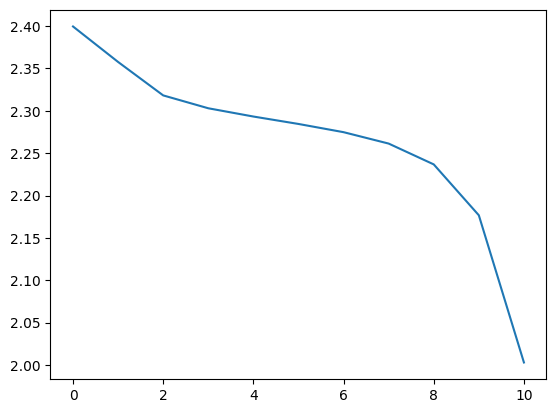

In [78]:
import matplotlib.pyplot as plt

plt.plot(cnn.loss_epoch)
plt.show()